In [193]:
include("../src/celerite.jl")
using celerite
using Plots
using Distributions

ArgumentError: ArgumentError: Package celerite not found in current path:
- Run `Pkg.add("celerite")` to install the celerite package.


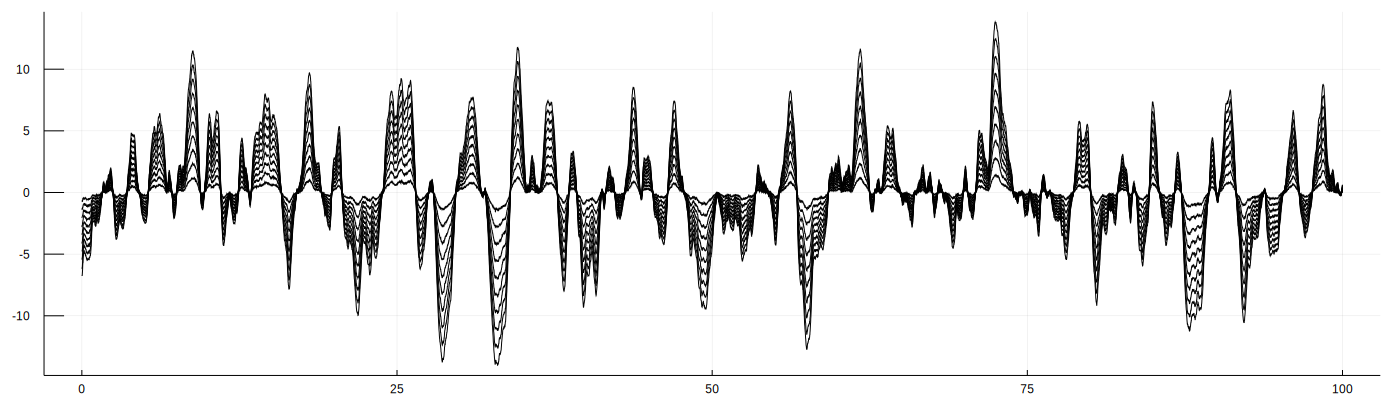

In [194]:
# parameters for kernel function
log_s = log(0.1)
log_q = log(1/sqrt(2))
log_w0 = 1

# define the second dimension's covariance 
c = collect(1:1:10)
n = length(c)
Q = broadcast(*, c, c')

# independent variable 
t = collect(0.0:0.01:100)

# define the gp
t1 = celerite.SHOTerm(log_s, log_q, log_w0)
u = randn(n*length(t))
gp = celerite.Celerite(t1, Q)

# compute the gp
logD = celerite.compute!(gp, t, 0.05, true)
# sample the gp
y = celerite.simulate_gp(gp, u)

# plot the samples
using Plots
plot(size=(1400,400), legend=false)
for i in 1:n
    plot!(t, y[i:n:end], linewidth=1, linealpha=1, color=:black)
end
current()

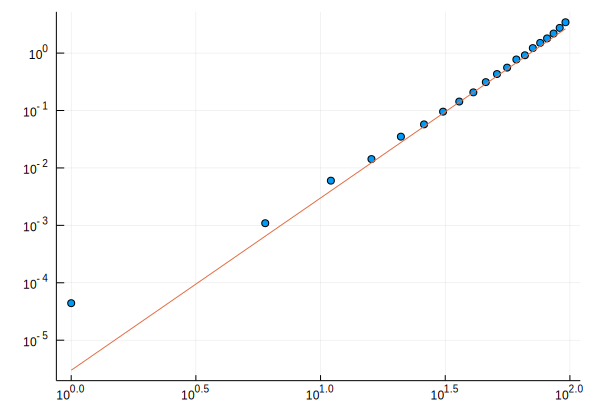

In [224]:
# time the computation as a function of the number of points in the second dimension, theoretical O(n^3)

# average computational time for n runs 
function time_compute(n, gp, t)
    sumtime = 0
    for i in 1:n
        sumtime += @elapsed celerite.compute!(gp, t, 0.01, true)
    end
    return sumtime/n
end

t = collect(0.0:0.1:10)
x = collect(1:5:100)
n = length(x)
time = zeros(n)

for (i, m) in enumerate(x)
    Q = ones(m, m)
    gp = celerite.Celerite(t1, Q)
    time[i] = time_compute(10, gp, t)
end

plot(x, time, xscale=:log10, yscale=:log10, markershape=:circle, linewidth=0, legend=false)
plot!(x, 3e-6*x.^3)

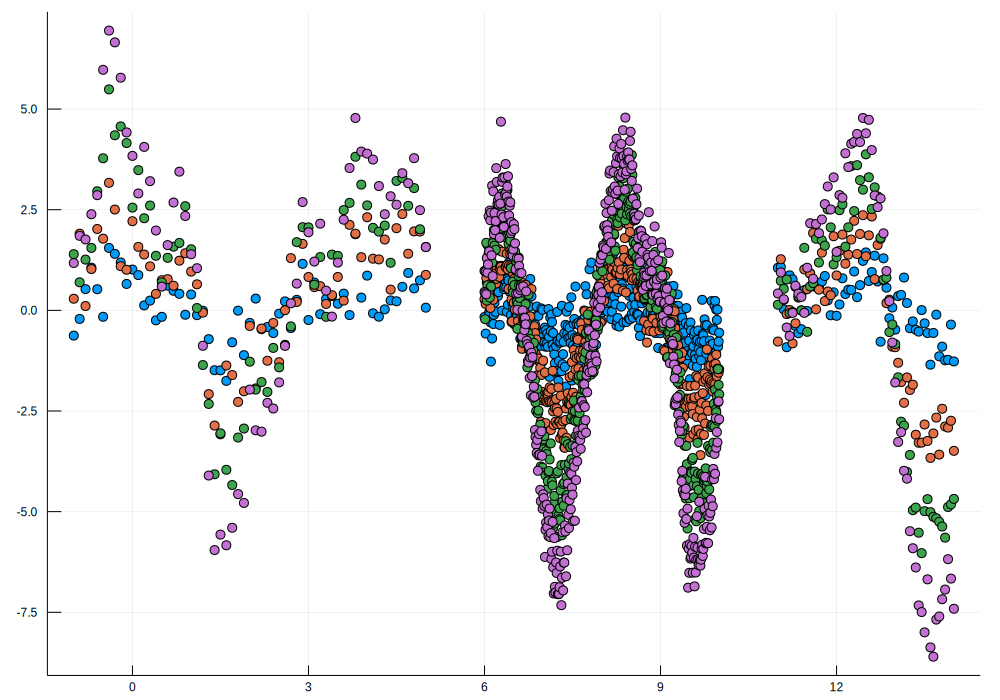

In [217]:
# prediction 

# create training set
t = vcat(collect(-1:0.1:5), collect(6:0.01:10), collect(11:0.05:14))
c = [1, 3, 5, 7]
Q = broadcast(*, c, c')
n = length(Q[1,:])
gp = celerite.Celerite(t1, Q)
logD = celerite.compute!(gp, t, 0.5, true)
u = randn(n*length(t))
y = celerite.simulate_gp(gp, u)
y_noisy = y
plot(size=(1000,700), legend=false)
for i in 1:n
    plot!(t, y_noisy[i:n:end], markershape=:circle, markersize=5, linewidth=0, markeralpha=1)
end
current()

minimized params:	[-2.429, -0.01014, 1.00452, 1.0951, 1.6644, 1.97291, -0.683649]
true:			[-2.30259, -0.346574, 1.0, 1.09861, 1.60944, 1.94591, -0.693147]


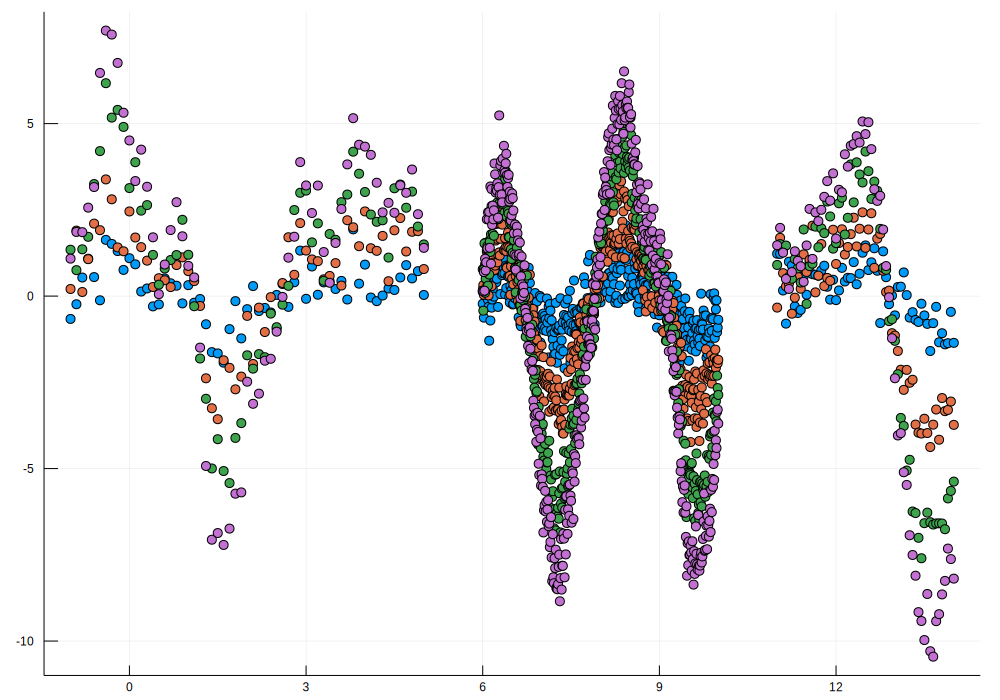

In [218]:
using Optim
using ForwardDiff

y = y_noisy
true_params = [log_s, log_q, log_w0, log(3), log(5), log(7), log(0.5)]

function setup_gp(p)
    t1 = celerite.SHOTerm(p[1], p[2], p[3])
    c = exp.([0., p[4], p[5], p[6]])
    Q = broadcast(*, c, c')
    gp = celerite.Celerite(t1, Q)
    celerite.compute!(gp, t, exp(p[7]), true)
    return gp
end

function nll(p)
    gp = setup_gp(p)
    ret = -celerite.log_likelihood(gp, y)
    return ret  
end

initial_guess = ones(length(true_params))
lower = -Inf*initial_guess
upper = Inf*initial_guess
lower[end] = -1.

res = optimize(nll, lower, upper, initial_guess, NelderMead())
println("minimized params:\t", res.minimizer)
println("true:\t\t\t", true_params)

n = 4
p = res.minimizer
gp = setup_gp(p)
yb = celerite.simulate_gp(gp, u)
plot(size=(1000,700), legend=false)
for i in 1:n
    plot!(t, yb[i:n:end], markershape=:circle, markersize=5, linewidth=0, markeralpha=1)
end
current()

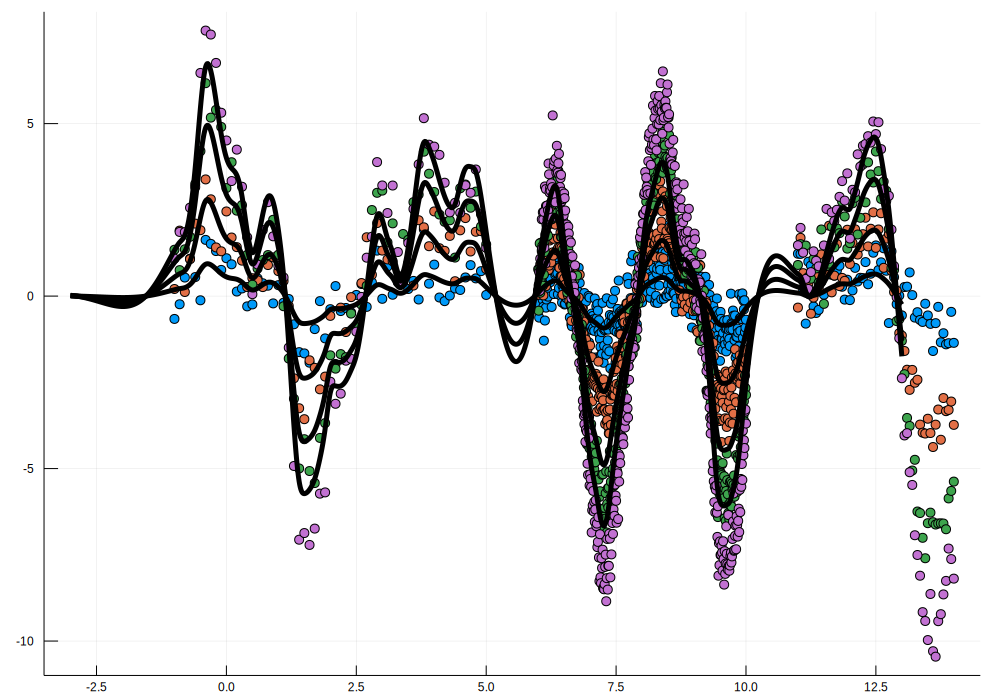

In [219]:
# maximum likelihood gp conditioned on original data: 
plot(size=(1000,700), legend=false)
for i in 1:n
    plot!(t, yb[i:n:end], markershape=:circle, markersize=5, linewidth=0, markeralpha=1)
end
current()

# predict
x = collect(-3:0.01:13)
pred = celerite.predict_myway!(gp, t, y, x)
for i in 1:n
    plot!(x, pred[:,i], linewidth=5, linealpha=1, color=:black)
end
current()

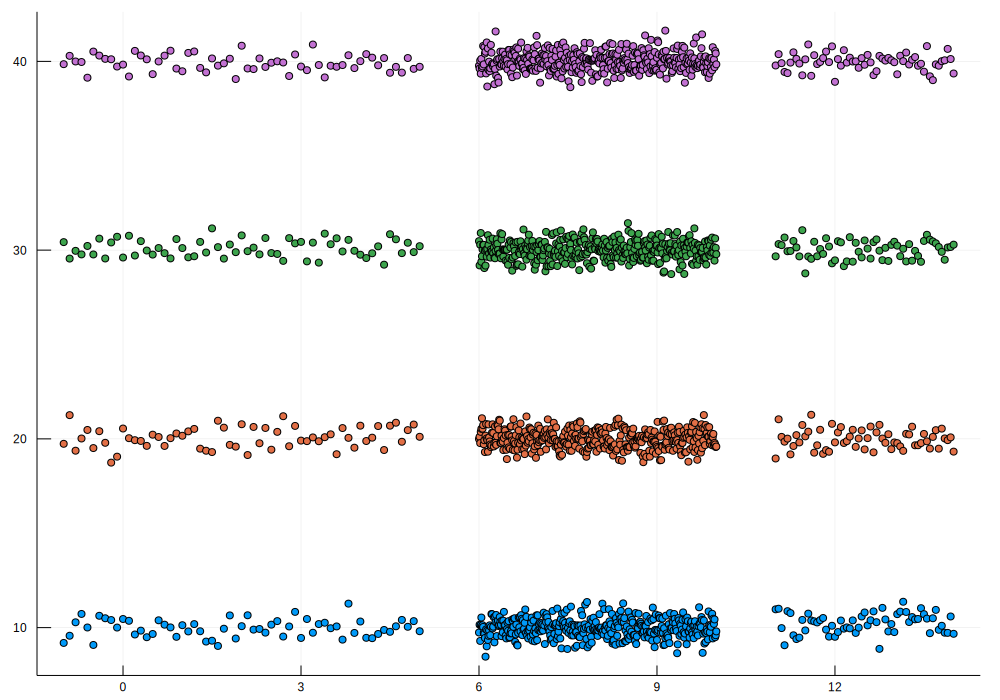

In [220]:
plot(size=(1000,700), legend=false)
pred = celerite.predict_myway!(gp, t, y, t)
for i in 1:n
    plot!(t, y[i:n:end] - pred[:,i] .+ 10*i, linewidth=0, marker=:circle, linealpha=1)
end
current()